In [1]:
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
sql="""
select
id,
name,
artist,
cast(substr(rel_date,0,5) as int) as rel_year,
case when (substr(rel_date,0,5) < '1910') then '1900s'
	when (substr(rel_date,0,5) >= '1910' and substr(rel_date,0,5) < '1920') then '1910s'
	when (substr(rel_date,0,5) >= '1920' and substr(rel_date,0,5) < '1930') then '1920s'
	when (substr(rel_date,0,5) >= '1930' and substr(rel_date,0,5) < '1940') then '1930s'
	when (substr(rel_date,0,5) >= '1940' and substr(rel_date,0,5) < '1950') then '1940s'
	when (substr(rel_date,0,5) >= '1950' and substr(rel_date,0,5) < '1960') then '1950s'
	when (substr(rel_date,0,5) >= '1960' and substr(rel_date,0,5) < '1970') then '1960s'
	when (substr(rel_date,0,5) >= '1970' and substr(rel_date,0,5) < '1980') then '1970s'
	when (substr(rel_date,0,5) >= '1980' and substr(rel_date,0,5) < '1990') then '1980s'
	when (substr(rel_date,0,5) >= '1990' and substr(rel_date,0,5) < '2000') then '1990s'
	when (substr(rel_date,0,5) >= '2000' and substr(rel_date,0,5) < '2010') then '2000s'
	when (substr(rel_date,0,5) >= '2010' and substr(rel_date,0,5) < '2020') then '2010s'
	end dateClass,
explicit,
case when (explicit = 0) then 'clean'
	when (explicit = 1) then 'explicit'
	end explicitClass,
time_signature,
key,
case when (key = -1) then 'No key'
	when (key = 0) then 'C'
	when (key = 1) then 'C sharp/D flat'
	when (key = 2) then 'D'
	when (key = 3) then 'D sharp/E flat'
	when (key = 4) then 'E'
	when (key = 5) then 'F'
	when (key = 6) then 'F sharp/G flat'
	when (key = 7) then 'G'
	when (key = 8) then 'G sharp/A flat'
	when (key = 9) then 'A'
	when (key = 10) then 'A sharp/B flat'
	when (key = 11) then 'B'
	end keyClass,
tempo,
case when (tempo <= 50) then 'very slow'
	when (tempo > 50 and tempo <= 100) then 'slow'
	when (tempo > 100 and tempo <= 150) then 'moderate'
	when (tempo > 150 and tempo <= 200) then 'fast'
	when (tempo > 200 and tempo <= 250) then 'very fast'
	end tempoClass,
mode,
case when (mode = 0) then 'minor'
	when (mode = 1) then 'major'
	end modeClass,
duration_ms,
case when (duration_ms <= 120000) then 'very short'
	when (duration_ms > 120000 and duration_ms <= 180000) then 'short'
	when (duration_ms > 180000 and duration_ms <= 240000) then 'medium'
	when (duration_ms > 240000 and duration_ms <= 300000) then 'long'
	when (duration_ms > 300000) then 'very long'
	end durationClass,
danceability,
case when (danceability <= 0.59) then 'low danceability'
	when (danceability > 0.59) then 'high danceability'
	end danceabilityClass,
valence,
case when (valence <= 0.25) then 'low valence'
	when (valence > 0.25 and valence <= 0.50) then 'low/moderate valence'
	when (valence > 0.50 and valence <= 0.75) then 'moderate/high valence'
	when (valence > 0.75) then 'high valence'
	end valenceClass,
energy,
case when (energy <= 0.25) then 'low energy'
	when (energy > 0.25 and energy <= 0.50) then 'low/moderate energy'
	when (energy > 0.50 and energy <= 0.75) then 'moderate/high energy'
	when (energy > 0.75) then 'high energy'
	end energyClass,
loudness,
case when (loudness < -45 ) then 'very quiet'
	when (loudness > -45 and loudness <= -30) then 'quiet'
	when (loudness > -30 and loudness <= -15) then 'moderate'
	when (loudness > -15 and loudness <= 0) then 'loud'
	when (loudness > 0 and loudness <= 15) then 'very loud'
	end loudnessClass,
speechiness,
case when (speechiness <= 0.33) then 'just music'
	when (speechiness > 0.33 and speechiness <= 0.66) then 'both music and speech'
	when (speechiness > 0.66) then 'just speech'
	end speechinessClass,
acousticness,
case when (acousticness <= 0.25) then 'low acousticness'
	when (acousticness > 0.25 and acousticness <= 0.50) then 'low/moderate acousticness'
	when (acousticness > 0.50 and acousticness <= 0.75) then 'moderate/high acousticness'
	when (acousticness > 0.75) then 'high acousticness'
	end acousticnessClass,
instrumentalness,
case when (instrumentalness <= 0.25) then 'less instrumental'
	when (instrumentalness > 0.25 and instrumentalness <= 0.75) then 'moderate instrumentalness'
	when (instrumentalness > 0.75) then 'more instrumental'
	end instrumentalnessClass,
liveness,
case when (liveness <= 0.33) then 'studio recording'
	when (liveness > 0.33 and liveness <= 0.66) then 'moderate liveness'
	when (liveness > 0.66) then 'live recording'
	end livenessClass
from song_analysis
where
key is not null
and tempo is not null
and mode is not null
and duration_ms is not null
and danceability is not null
and valence is not null
and energy is not null
and loudness is not null
and speechiness is not null
and instrumentalness is not null
and substr(rel_date,0,5) >= '1899'
and tempo != 0.0
and time_signature != 0
and liveness is not null
and duration_ms >= 60000;
"""

In [3]:
conn = sqlite3.connect('spotify_song_data.db')
c = conn.cursor()

dfSpotify = pd.read_sql_query(sql, conn)
dfSpotify = dfSpotify.dropna()
conn.close()
dfSpotify.head(10)

,id,name,artist,rel_year,dateClass,explicit,explicitClass,time_signature,key,keyClass,...,loudness,loudnessClass,speechiness,speechinessClass,acousticness,acousticnessClass,instrumentalness,instrumentalnessClass,liveness,livenessClass
0,6nNED0S6N5oWBmpdM7VCnE,Calling,Groovecatcher,2006,2000s,0,clean,4,9,A,...,-7.305,loud,0.0323,just music,0.009450,low acousticness,0.019500,less instrumental,0.1270,studio recording
1,4oWaq1NqE5K3HKCTQhJTnr,Athina-Saloniki me mia papoutsothiki,Imiskoubria,2008,2000s,0,clean,4,7,G,...,-8.657,loud,0.1920,just music,0.034800,low acousticness,0.000000,less instrumental,0.0748,studio recording
2,1Yhg8pkTNyzn9lQPUSHed1,Sing The Absurd,The Wonder Stuff,1993,1990s,0,clean,3,7,G,...,-9.729,loud,0.0335,just music,0.001690,low acousticness,0.000011,less instrumental,0.0757,studio recording
3,4kZShGNaLMWSfN4MVYXz6A,Donde El Rio Hierve + Perdido En La Ciudad,M-Clan,2001,2000s,0,clean,4,0,C,...,-5.563,loud,0.2450,just music,0.547000,moderate/high acousticness,0.000158,less instrumental,0.9770,live recording
4,1p8fQJTQnmSBt5SItyV2Vb,Carolina Moon - Remastered 2013,Thelonious Monk,2014,2010s,0,clean,3,2,D,...,-8.439,loud,0.0324,just music,0.622000,moderate/high acousticness,0.053500,less instrumental,0.1110,studio recording
5,57ttB1s87EOU6BO27OznZN,Can You Dig It?,Roy Ayers,2009,2000s,0,clean,4,1,C sharp/D flat,...,-13.656,loud,0.0286,just music,0.211000,low acousticness,0.319000,moderate instrumentalness,0.1170,studio recording
6,7t8phj8RZWRvtyxH8on2Vj,Voodoo,Scan X,1996,1990s,0,clean,4,10,A sharp/B flat,...,-11.656,loud,0.0704,just music,0.664000,moderate/high acousticness,0.923000,more instrumental,0.1420,studio recording
7,3vawllIrk1nVb9m1ZPJlv8,Surreal Catharsis,Tragic Black,2013,2010s,0,clean,4,11,B,...,-4.454,loud,0.0699,just music,0.000064,low acousticness,0.001590,less instrumental,0.2160,studio recording
8,4fxC5rVzklYTra16z47omj,Queen Of Flies,Auto-Auto,2005,2000s,0,clean,4,1,C sharp/D flat,...,-6.052,loud,0.0316,just music,0.004790,low acousticness,0.212000,less instrumental,0.1280,studio recording
9,2akTVZIsl4YuUgw5oCxHiZ,Rockin' Maybelle,Dex Romweber,2001,2000s,0,clean,4,9,A,...,-4.164,loud,0.1750,just music,0.027400,low acousticness,0.010900,less instrumental,0.3200,studio recording


In [4]:
# Correlation coefficients for all attributes
dfSpotify.corr()

,rel_year,explicit,time_signature,key,tempo,mode,duration_ms,danceability,valence,energy,loudness,speechiness,acousticness,instrumentalness,liveness
rel_year,1.000000,0.055912,0.014086,0.006560,0.023421,-0.045739,0.039878,0.037484,-0.070883,0.139956,0.213682,0.049351,-0.109527,0.055456,0.018627
explicit,0.055912,1.000000,0.029163,0.011719,-0.040155,-0.031311,-0.036015,0.096993,0.031537,0.105821,0.109805,0.297475,-0.105366,-0.087741,0.048333
time_signature,0.014086,0.029163,1.000000,0.012142,0.000887,-0.015041,0.007845,0.156948,0.131496,0.172956,0.130741,0.000356,-0.167494,-0.024275,-0.001396
key,0.006560,0.011719,0.012142,1.000000,0.001318,-0.180758,0.007862,0.024511,0.020318,0.038373,0.022037,0.024175,-0.035065,0.002563,-0.004538
tempo,0.023421,-0.040155,0.000887,0.001318,1.000000,0.012074,-0.006460,-0.103985,0.091886,0.222162,0.163458,-0.030407,-0.187927,0.008072,0.007249
mode,-0.045739,-0.031311,-0.015041,-0.180758,0.012074,1.000000,-0.072453,-0.048571,0.023260,-0.045265,-0.009315,-0.042214,0.055827,-0.067196,0.007497
duration_ms,0.039878,-0.036015,0.007845,0.007862,-0.006460,-0.072453,1.000000,-0.017024,-0.194049,-0.009832,-0.079716,-0.031210,-0.074896,0.209350,0.012248
danceability,0.037484,0.096993,0.156948,0.024511,-0.103985,-0.048571,-0.017024,1.000000,0.516527,0.055103,0.108069,0.136276,-0.113695,-0.111556,-0.120933
valence,-0.070883,0.031537,0.131496,0.020318,0.091886,0.023260,-0.194049,0.516527,1.000000,0.266836,0.235850,0.053015,-0.146084,-0.234968,-0.009939
energy,0.139956,0.105821,0.172956,0.038373,0.222162,-0.045265,-0.009832,0.055103,0.266836,1.000000,0.763699,0.114013,-0.717322,-0.076536,0.153360


In [5]:
dfSpotify.columns

Index(['id', 'name', 'artist', 'rel_year', 'dateClass', 'explicit',
       'explicitClass', 'time_signature', 'key', 'keyClass', 'tempo',
       'tempoClass', 'mode', 'modeClass', 'duration_ms', 'durationClass',
       'danceability', 'danceabilityClass', 'valence', 'valenceClass',
       'energy', 'energyClass', 'loudness', 'loudnessClass', 'speechiness',
       'speechinessClass', 'acousticness', 'acousticnessClass',
       'instrumentalness', 'instrumentalnessClass', 'liveness',
       'livenessClass'],
      dtype='object')

In [6]:
attributes_full = ['rel_year','explicit','time_signature','key','tempo','mode','energy','loudness','speechiness',
                   'acousticness','instrumentalness','liveness','valence']

X = dfSpotify[attributes_full]
y = dfSpotify['danceabilityClass']

In [7]:
# Fit a logistic regression classifier for danceability with all relevant attributes
# NOTE: including duration makes model much worse
dance_clf_full = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X, y)

In [8]:
# Take random sample from the data frame to test the classifier
dfTestFullClf = dfSpotify.sample(10000)

# make a list of the actual dancibility for each song in the sample to compare against the predictions
actual_danceability_full = list(dfTestFullClf['danceabilityClass'])

dfTestFullClf = dfTestFullClf[attributes_full]

In [9]:
def compare_predictions_to_data(pred_list, actual_list):
    num_wrong = 0
    num_right = 0
    for tupe in zip(pred_list, actual_list):
        if tupe[0] != tupe[1]:
            num_wrong += 1
            #print("Predicted: {} Actual: {}".format(tupe[0], tupe[1]))
        else:
            num_right += 1
    print("\nCorrect: {}\nIncorrect: {}\nPercent Correct: {}".format(num_right, num_wrong, 
                                                                     num_right/(num_right+num_wrong)))

In [10]:
danceability_preds_full = dance_clf_full.predict(dfTestFullClf)

compare_predictions_to_data(danceability_preds_full, actual_danceability_full)


Correct: 7232
Incorrect: 2768
Percent Correct: 0.7232


In [11]:
dance_clf_full.classes_

array(['high danceability', 'low danceability'], dtype=object)

In [12]:
def graph_probs_of_misclassified(df, attributes, clf, n_sample):
    dfTest = df.sample(n_sample)
    actual = dfTest['danceabilityClass']
    dfTest = dfTest[attributes]
    
    preds = clf.predict(dfTest)
    
    probs_of_misclassified = list()
    
    for i, tupe in enumerate(zip(preds, actual)):
        if tupe[0] != tupe[1]:
            row = dfTest.iloc[[i]]
            #print(row)
            # list of prob high danceability, low danceability
            class_probs = clf.predict_proba(row)
            if tupe[1] == 'high danceability':
                prob_correct_class = class_probs[0][0]
            else:
                prob_correct_class = class_probs[0][1]
                
            probs_of_misclassified.append(prob_correct_class)
            
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    
    ax.scatter(np.arange(len(probs_of_misclassified)),probs_of_misclassified, alpha = 0.6)
    
    ax.set_xlabel("Misclassified Songs")
    ax.set_ylabel("Probability of Correct Class Label")
    ax.set_title("Probability of Correct Class Label for Misclassified Songs")
    

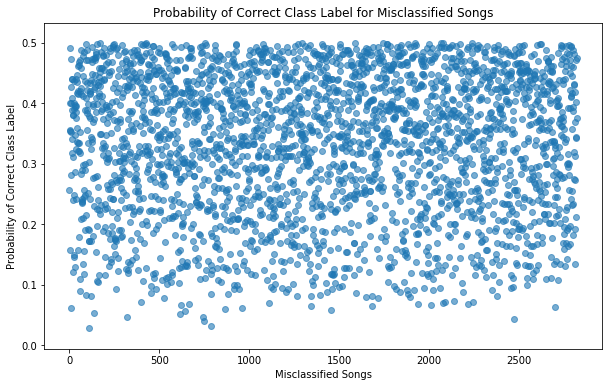

In [13]:
graph_probs_of_misclassified(dfSpotify, attributes_full, dance_clf_full, 10000)

In [14]:
rfe = RFE(dance_clf_full)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True False False False  True False  True  True False  True
  True]
[8 2 1 7 6 4 1 5 1 1 3 1 1]


In [15]:
attributes_reduced = [att[1] for att in zip(rfe.support_, attributes_full) if att[0] == True]
print("Most important attributes for predicting danceability:\n", attributes_reduced)

Most important attributes for predicting danceability:
 ['time_signature', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence']


In [16]:
X_red = dfSpotify[attributes_reduced]

# train a new classifier on the reduced attribute set
dance_clf_red = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(X_red, y)

In [17]:
# Take random sample from the data frame to test the classifier
dfTestRedClf = dfSpotify.sample(10000)

# make a list of the actual dancibility for each song in the sample to compare against the predictions
actual_danceability_red = list(dfTestRedClf['danceabilityClass'])

dfTestRedClf = dfTestRedClf[attributes_reduced]

In [18]:
danceability_preds_red = dance_clf_red.predict(dfTestRedClf)

compare_predictions_to_data(danceability_preds_red, actual_danceability_red)


Correct: 7220
Incorrect: 2780
Percent Correct: 0.722


### As we can see, the reduced model performed as well as the full model for predicting danceability using logistic regression.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [23]:
# X = dfSpotify[attributes_full]
train, test = train_test_split(dfSpotify, test_size=0.2)

# use reduced feature set b/c curse of dimensionality makes full model much worse
train_X = train[attributes_reduced]
train_y = train['danceabilityClass']

test_X = test[attributes_reduced]
test_y = test['danceabilityClass']

In [24]:
knn = KNeighborsClassifier()
knn = knn.fit(train_X, train_y) 
# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
#            weights='uniform')


In [25]:
danceability_preds_knn = knn.predict(test_X)

compare_predictions_to_data(danceability_preds_knn, test_y)


Correct: 96745
Incorrect: 38611
Percent Correct: 0.7147448210644523


In [26]:
len(dfSpotify)

676778